In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [2]:
# 1. amit 데이터 읽기
# Y1 = TOT, Y2 = AMI, 
# Z1 = GEN(1 = femaile, 0 = male), Z2 = AMT, Z3 = PR, Z4 = DIAP, Z5 = QRS

amit = pd.read_csv('amit.dat', header=None, delim_whitespace=True)
amit.columns = ['Y1', 'Y2', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5']
amit

,Y1,Y2,Z1,Z2,Z3,Z4,Z5
0,3389,3149,1,7500,220,0,140
1,1101,653,1,1975,200,0,100
2,1131,810,0,3600,205,60,111
3,596,448,1,675,160,60,120
4,896,844,1,750,185,70,83
5,1767,1450,1,2500,180,60,80
6,807,493,1,350,154,80,98
7,1111,941,0,1500,200,70,93
8,645,547,1,375,137,60,105
9,628,392,1,1050,167,60,74


### a. Perform a multivariate regression analysis. Analyze the residuals to check the multivariate normal assumption (Python and cqplot).

In [3]:
# regression coefficient estimation

amit['Z0'] = np.ones(len(amit))
amit= amit[['Y1', 'Y2', 'Z0','Z1', 'Z2', 'Z3', 'Z4', 'Z5']]

Y0 = amit.iloc[:,:2]
X0 = amit.iloc[:,2:]

beta = np.linalg.inv(X0.T @ X0) @ X0.T @ Y0
beta = beta.rename(index = {0:'beta0', 1:'beta1', 2:'beta2', 3:'beta3', 4:'beta4', 5:'beta5'})
beta

,Y1,Y2
beta0,-2879.478246,-2728.708544
beta1,675.650781,763.029762
beta2,0.284851,0.306373
beta3,10.272133,8.896198
beta4,7.251171,7.205560
beta5,7.598240,4.987051


In [4]:
# Residual

residual = Y0 - np.array(X0) @ np.array(beta)
residual

,Y1,Y2
0,132.821721,161.527686
1,-72.003916,-264.353294
2,-399.247694,-373.852438
3,-382.847295,-247.294565
4,-152.391292,15.787769
5,366.786445,217.132056
6,4.499942,-83.742102
7,294.556802,462.724007
8,101.840674,223.035763
9,-180.052350,-251.053639


In [5]:
# chi-square plot 출력 함수

def chisquareplot(data):
    
    # Calculate the squared generalized distances 
    d_list = []
    for i in range(len(data)) :
        mean_v = data.mean()
        v = data.iloc[i,:] - mean_v
        s = np.subtract(data, mean_v.transpose())
        cov_v = s.transpose().dot(data) / (len(data)-1)
        cov_inv = np.linalg.inv(cov_v)
        d = v.T @ cov_inv @ v
        d_list.append(d)
        d_list.sort()
    
    # Calculate probability values
    size = len(data)
    a = list(range(1,size+1, 1))
    percent = (np.array(a) - np.ones(len(a))*1/2) / len(a)
    
    # Calculate quantiles of theoretical chi-square distribution
    q = stats.chi2.ppf(percent, data.shape[1])
    
    # Plot the pairs
    fig, ax = plt.subplots()
    ax.scatter(q, d_list)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color = 'red')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.title('Chi-square Plot')
    return plt.show()

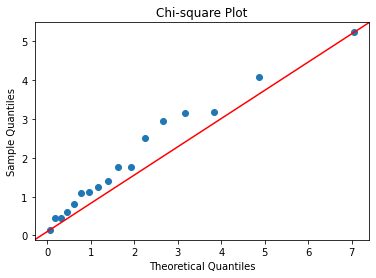

In [6]:
# cq plot을 통한 residual 정규성 검정

chisquareplot(residual)

### b. Construct a 95% simultaneous confidence interval for E(Y1) at Z1=1, Z2=1200, Z3=140, Z4=70, Z5=85. (Python)

In [7]:
from scipy.stats import f

X_new = np.array([1, 1,1200,140,70,85])
Y_new = beta.T @ X_new
Y_new_1 = Y_new[0]

n = len(residual)
m = len(Y0.columns)
r = len(beta)-1
alpha = 0.05
sigma = 1/n * residual.T @ residual
f = f.ppf(1-alpha, m, n-r-m, loc=0, scale=1)
H = (X_new.T @ np.linalg.inv(X0.T @ X0) @ X_new)

upper = Y_new_1 + np.sqrt((m*(n-r-1)) / (n-r-m) * f) * np.sqrt( H * (n/(n-r-1) * sigma.iloc[0,0]))
lower = Y_new_1 - np.sqrt((m*(n-r-1)) / (n-r-m) * f) * np.sqrt( H * (n/(n-r-1) * sigma.iloc[0,0]))

print("Simultaneous confidence interval : lower = {}, upper = {}".format(lower, upper))

Simultaneous confidence interval : lower = 319.02024178485965, upper = 1140.0293024396224


### c. Construct a 95% simultaneous confidence interval for individual Y2 at Z1=1, Z2=1200, Z3=140, Z4=70, Z5=85. (Python)

In [8]:
from scipy.stats import f

X_new = np.array([1, 1,1200,140,70,85])
Y_new = beta.T @ X_new
Y_new_2 = Y_new[1]

n = len(residual)
m = len(Y0.columns)
r = len(beta)-1
alpha = 0.05
sigma = 1/n * residual.T @ residual
f = f.ppf(1-alpha, m, n-r-m, loc=0, scale=1)
H = (X_new.T @ np.linalg.inv(X0.T @ X0) @ X_new)

upper = Y_new_2 + np.sqrt((m*(n-r-1)) / (n-r-m) * f) * np.sqrt((1 + H) * (n/(n-r-1) * sigma.iloc[1,1]))
lower = Y_new_2 - np.sqrt((m*(n-r-1)) / (n-r-m) * f) * np.sqrt((1 + H) * (n/(n-r-1) * sigma.iloc[1,1]))

print("Simultaneous confidence interval : lower = {}, upper = {}".format(lower, upper))

Simultaneous confidence interval : lower = -401.06528932432855, upper = 1552.516223863271


### d.

In [9]:
sigma_hat = 1/n * (Y0 - np.array(X0) @ np.array(beta)).T @ (Y0 - np.array(X0) @ np.array(beta))
sigma_hat

,Y1,Y2
Y1,51176.959440,45039.792706
Y2,45039.792706,55335.817611


### e. Compute the Wilk's lambda value to test whether (Y1, Y2) are not dependent on (Z3, Z4, Z5). (Use Python).

In [10]:
# Reduced model
X_r = X0.iloc[:,:-3]
beta_r = np.linalg.inv(X_r.T @ X_r) @ X_r.T @ Y0

sigma1_hat = 1/n * (Y0 - np.array(X_r) @ np.array(beta_r)).T @ (Y0 - np.array(X_r) @ np.array(beta_r))
E1 = n*sigma1_hat

# Full model
E = n*sigma_hat
H = E1-E

# Wilk's Lambda
w = np.linalg.det(E) / np.linalg.det(E+H)

print("Wilk's lambda = {}".format(w))

Wilk's lambda = 0.4405021444258209


### f. Test the null hypothesis that (Y1, Y2) are not dependent on (Z3, Z4, Z5) at 𝛼 = 0.05. (Use Python).

In [11]:
from numpy import log as ln
from scipy.stats import chi2

n= len(Y0)
m = len(Y0.columns)
r = len(beta)-1
q = len(X_r.columns) -1
alpha = 0.05

stat = -(n-r-1-1/2*(m-r+q+1))*ln(w)
c_region = chi2.ppf(1-alpha, m*(r-q), loc=0, scale=1)
p_value = chi2.sf(stat, m*(r-q))

# Hypothesis Testing
if stat > c_region :
    print("p-value = {:.10f}".format(p_value))
    print("Reject the null hypothesis")
else :
    print("p-value = {}".format(p_value))
    print("Do not reject the null hypothesis")

p-value = 0.17255488315211853
Do not reject the null hypothesis


In [12]:
from statsmodels.multivariate.manova import MANOVA

maov = MANOVA.from_formula('Y1+Y2 ~ Z1+Z2+Z3+Z4+Z5', data = amit)
print(maov.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.5105 2.0000 10.0000  4.7936 0.0347
         Pillai's trace 0.4895 2.0000 10.0000  4.7936 0.0347
 Hotelling-Lawley trace 0.9587 2.0000 10.0000  4.7936 0.0347
    Roy's greatest root 0.9587 2.0000 10.0000  4.7936 0.0347
------------------------------------------------------------
                                                            
------------------------------------------------------------
           Z1           Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3448 2.0000 10.0000  9.5015 0.0049
         Pillai's trace 0.6552 2.0000 10.0000  9.5015 0.0049
 Hotelling-Lawley trace 1.9003 2.0000 10.0